# Robustness in Regulatory Networks
## A tutorial for BoolNet and BoolNetPerturb

* [Introduction](#Introduction)
    * [Robustness and plasticity in biological systems](#Robustness-and-plasticity-in-biological-systems)
    * [Regulatory Networks](#Regulatory Networks)
    * [Biological system: Th17/iTreg network](#Biological system: Th17/iTreg network)
* [Attractors of the network](#Attractors of the network)
    * [Labels](#Labels)
* [Function perturbations](#Function perturbations)
    * [Knock-out and over-expression](#Knock-out and over-expression)
    * [Fixed environments](#Fixed environments)
    * [Truth table](#Truth table)
* [Updating perturbations](#Updating perturbations)
    * [Synchronous vs asynchronous](#Synchronous-vs-asynchronous)
    * [Transition table](#Transition-table)
* [States and trajectories](#States-and-Trajectories)
* [Conclusions](#Conclusions)

# Introduction

[//]: # (## About)

This tutorial explains how to use [BoolNet](https://cran.r-project.org/web/packages/BoolNet/index.html) and [BoolNetPerturb](https://github.com/mar-esther23/boolnet-perturb) to study the robustness of Boolean regulatory networks and the biological implications of this analysis.

This tutorial supposes that the reader is familiar with the basic concepts of:
* __Boolean regulatory networks__. There are a lot of basic introductions to the topic like: [Kaplan & Glass, 1995](https://books.google.com.mx/books?id=kfmThocv1qsC&pg=PA55#v=onepage&q&f=false), [Azpeitia 2011](http://journal.frontiersin.org/article/10.3389/fpls.2011.00092/abstract) and [Albert 2014](http://onlinelibrary.wiley.com/doi/10.1002/wsbm.1273/full). [CoLoMoTo](http://www.colomoto.org/) also published a more advanced review [CoLoMoTo 2015](http://www.biorxiv.org/content/biorxiv/early/2014/10/19/010504.full.pdf). 
* __R programming language__. A good starting point is the [R programming course](https://www.coursera.org/course/rprog) at Coursera.
* __Molecular biology__. Contact your local biologist.
* __Robustness__. The book [Wagner 2005](https://books.google.com.mx/books?id=pRFYAQAAQBAJ&printsec=frontcover#v=onepage&q&f=false) was a great inspiration for this work.

The standar format for logical regulatory networks is [SBML-qual](http://www.colomoto.org/formats/sbml-qual.html).

## Robustness and plasticity in biological systems

Organisms develop in a changing world where they are exposed to intrinsic and extrinsic perturbations. Because of this perturbations, they need to be both resilient and adaptable, depending of the situation. This two behaviors coexist in all organisms, which suggests that there are common mechanism that underlie both robustness and plasticity. 

Robustness is the capacity of an organism of maintaining its biological function in response to perturbations. A system is stable if it returns to a state after a perturbation, and plastic if it transitions to a new one. However, for studying robustness it is necessary to determine _what_ function of the system is robust to _which_ kind of perturbations\cite{Wagner2005}.

## Regulatory Networks

Regulatory Networks (RN) are a useful tool for studying the cellular behaivor and robustness of biological systems in response to different kinds of perturbations\citeColomoto2015}. RN integrate the available information of the molecular regulation to predict cellular level phenomena using a mathematical formalism. RN  are deterministic dynamic systems. RN consist of nodes -that represent genes, proteins, or other biological processes- and edges -that represent the regulatory interactions among the nodes.  Using this information, it is possible to construct functions that describe the state of the nodes depending on the state of its regulators. The value of the node represents wether the gene or protein is active or inactive in the biological system. The effect of the environment can be included in this models as input nodes. 

The functions of the network are evaluated to obtain the attractors of the network. Attractors represent stable states in the dynamics of the network and have been related to cell types or  biological processes like the cell cycle\cite{Gerherson2004,Kaufman,reviewReka} [Figure 1]. RN let us simulate multiple types of perturbations depending in which part of the RN we alter. We can say that an _attractor_ is stable to a perturbation if the RN returns to the same attractor, or plastic if it transitions to a different attractor. The robustness of the _system_ is the result of the stability or plasticity of all its attractors. The robustness of the system can differ depending on the perturbation. In this way, robustness is a characteristic of the system that emerges from the dynamic properties that emerge from the interactions between the components of the system.

<img src="images/DiagramGRN.png">


## Biological system: Th17/iTreg network

In this work we will use the Th17/iTreg regulatory network as an example. CD4 + T cells are fundamental for the adaptive immune response. They integrate the signals of the environment and differentiate from naive (Th0) cells into different cell types (Th1, Th2, Th17, iTreg, etc), which activate different parts of the immune system. In particular, Th17 cells have been associated with the inflammatory response and iTreg cells with the regulation of the inflammatory response.

CD4+ T cells begin as naïve Th0 cells, which do not express a transcription factor. These cells are activated by antigen presentation and differentiate depending in the cytokines in the environment. In the presence of IL-6 or IL-21 and TGF$\beta$ Th0 cells differentiate into Th17 cells and express ROR$\gamma$t, IL-21 and IL-17. In the presence of IL-2 and TGF$\beta$ Th0 cells differentiate into iTreg cells and express Foxp3 and TGF$\beta$. These cytokines and transcription factors regulate each other and their relationships can be visualized a as graph.

<figure>
    <a href="images/minTh17iTreg.png">
       <img src="images/minTh17iTreg.png" alt="Th17/iTreg regulatory network">
    </a>
<figcaption>
    Th17/iTreg regulatory network
</figcaption>
</figure>

The Th17/iTreg network can be expressed as a set of boolean functions obtained from the known interactions among the cytokines and transcription factors. Cyyokines are intrinsic if produced by the CD4+ T cell, and extrinsic if produced by other cells of the immune system. We will distinguish extrinsic cytokines by adding _e_ at the end of the cytokine name.

In [2]:
#Uncomment next line if you haven't installed BoolNet
#install.packages("BoolNet", repos='http://cran.us.r-project.org')
library(BoolNet)

## Uncomment next lines if you haven't installed BoolNetPerturb
#library(devtools)
#install_github("mar-esther23/boolnet-perturb", force = TRUE)
library(BoolNetPerturb)

# Delete this in oficial pdf
fileConn<-file("minTh17iTreg.txt")
writeLines(c(
    "targets, functions",
    "IL2, (IL2e | (IL2 &  ! FOXP3)) &  ! STAT3",
    "RORGT, (STAT3 & TGFB) &  ! FOXP3",
    "STAT3, (IL21e | STAT3 | RORGT) &  ! IL2",
    "FOXP3, (IL2 & (TGFB | FOXP3)) &  ! (STAT3 | RORGT)",
    "TGFB, TGFBe | ((TGFB | FOXP3) &  ! STAT3 )",
    "IL2e, IL2e",
    "IL21e, IL21e",
    "TGFBe, TGFBe"
    ), fileConn)
close(fileConn)
#End delete

net <- loadNetwork("minTh17iTreg.txt")
net

Boolean network with 8 genes

Involved genes:
IL2 RORGT STAT3 FOXP3 TGFB IL2e IL21e TGFBe

Transition functions:
IL2 = (IL2e | (IL2 &  ! FOXP3)) &  ! STAT3
RORGT = (STAT3 & TGFB) &  ! FOXP3
STAT3 = (IL21e | STAT3 | RORGT) &  ! IL2
FOXP3 = (IL2 & (TGFB | FOXP3)) &  ! (STAT3 | RORGT)
TGFB = TGFBe | ((TGFB | FOXP3) &  ! STAT3 )
IL2e = IL2e
IL21e = IL21e
TGFBe = TGFBe

# Attractors of the network

As the state of the network is updated using the functions, the network will reach a previously visited state called an attractor. Attractors can be steady states or cycles. The set of states that lead to an attractor is called the basin of the attractor. Attractors represent cell types or  biological processes. 
It is very important to verify that all the expected cell types appear in our attractors, if they are not present we might be missing interactions. It is also important to see if there are attractors that do not correspond to known cell types, as they may be predictions or show errors in the construction of the network.


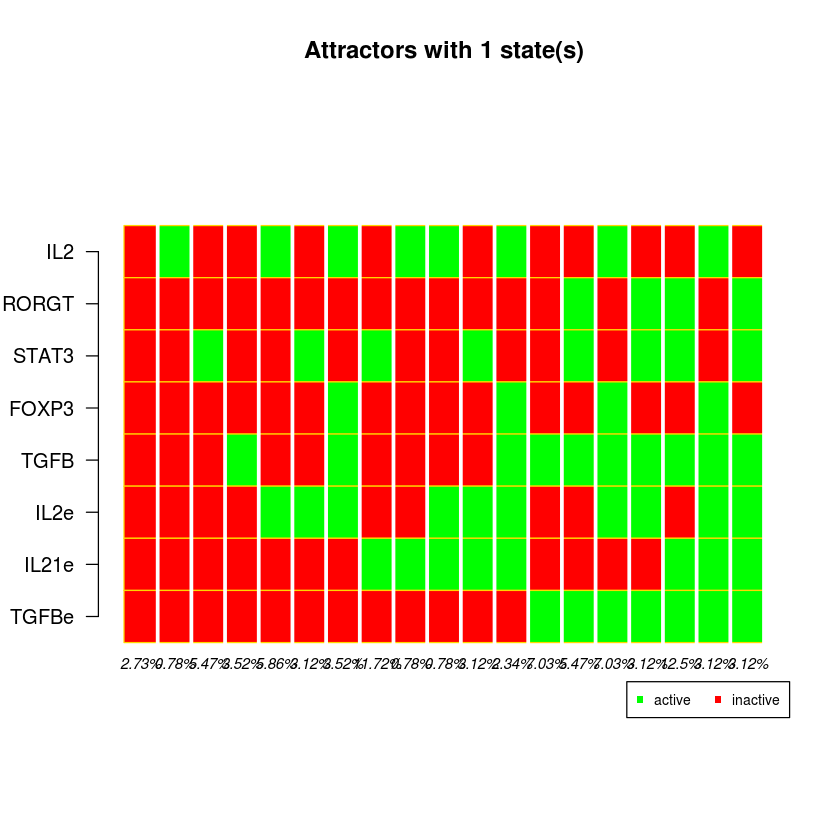

$`1`
:   1. 0
2. 0
3. 0
4. 0
5. 0
6. 0
7. 0
8. 0
9. 1
10. 0
11. 0
12. 0
13. 0
14. 0
15. 0
16. 0
17. 0
18. 0
19. 1
20. 0
21. 0
22. 0
23. 0
24. 0
25. 0
26. 0
27. 0
28. 0
29. 1
30. 0
31. 0
32. 0
33. 1
34. 0
35. 0
36. 0
37. 0
38. 1
39. 0
40. 0
41. 0
42. 0
43. 1
44. 0
45. 0
46. 1
47. 0
48. 0
49. 1
50. 0
51. 0
52. 1
53. 1
54. 1
55. 0
56. 0
57. 0
58. 0
59. 1
60. 0
61. 0
62. 0
63. 1
64. 0
65. 1
66. 0
67. 0
68. 0
69. 0
70. 0
71. 1
72. 0
73. 1
74. 0
75. 0
76. 0
77. 0
78. 1
79. 1
80. 0
81. 0
82. 0
83. 1
84. 0
85. 0
86. 1
87. 1
88. 0
89. 1
90. 0
91. 0
92. 1
93. 1
94. 1
95. 1
96. 0
97. 0
98. 0
99. 0
100. 0
101. 1
102. 0
103. 0
104. 1
105. 0
106. 1
107. 1
108. 0
109. 1
110. 0
111. 0
112. 1
113. 1
114. 0
115. 0
116. 1
117. 1
118. 1
119. 0
120. 1
121. 0
122. 1
123. 1
124. 0
125. 1
126. 1
127. 0
128. 1
129. 0
130. 1
131. 1
132. 0
133. 1
134. 0
135. 1
136. 1
137. 1
138. 0
139. 0
140. 1
141. 1
142. 1
143. 1
144. 1
145. 0
146. 1
147. 1
148. 0
149. 1
150. 1
151. 1
152. 1



$`2`
:   1. 0
2. 0
3. 0
4. 0
5. 0
6. 1
7. 1
8. 0
9. 1
10. 0
11. 1
12. 0
13. 0
14. 1
15. 1
16. 0
17. 0
18. 1
19. 0
20. 0
21. 1
22. 1
23. 0
24. 1
25. 1
26. 0
27. 1
28. 0
29. 1
30. 1
31. 0
32. 1
33. 0
34. 1
35. 0
36. 0
37. 1
38. 1
39. 1
40. 1
41. 1
42. 0
43. 1
44. 0
45. 1
46. 1
47. 1
48. 1







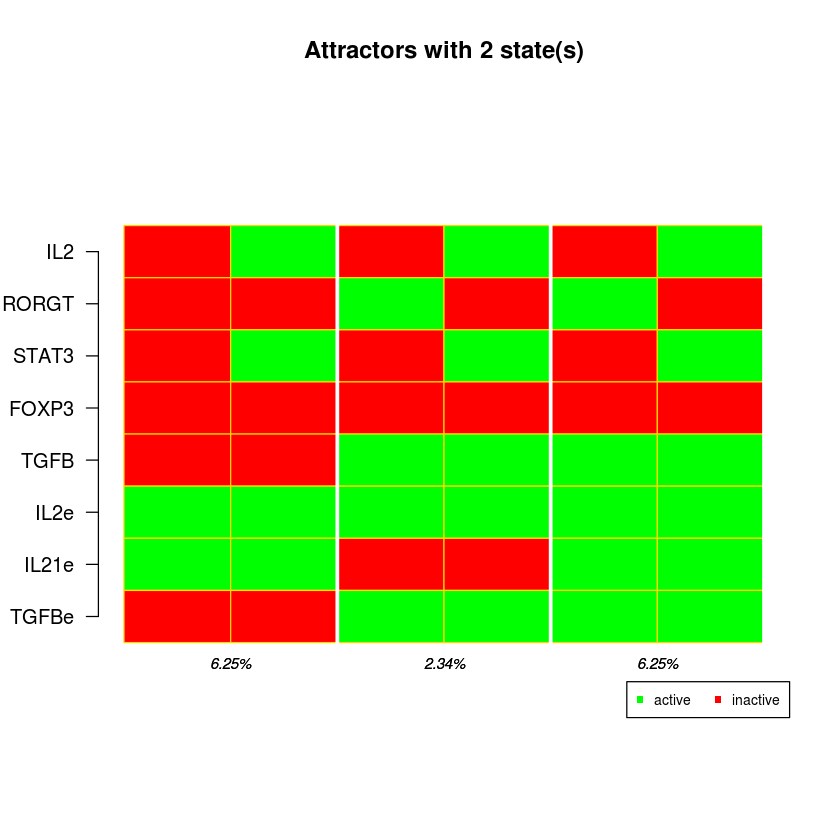

In [3]:
attr <- getAttractors(net)
plotAttractors(attr)

## Labels

When there are a lot of inputs, it is possible that many attractors correspond to a single cell type that can be found in different environments (we will discuss this further). We will consider that an attractor corresponds to a cell type if both the master transcription factor and characteristic cytokine are active.

In [4]:
labels.rules <- data.frame(
    labels=c('Th0', 'Th17', 'Treg', 'TGFB+', 'RORGT+', 'FOXP3+'),
    rules= c('!(RORGT | FOXP3 | TGFB)', 'RORGT & STAT3', 'FOXP3 & TGFB', 'TGFB & ! (RORGT | FOXP3)', 'RORGT & ! STAT3', 'FOXP3 & ! TGFB')
    )
labels.rules

labels,rules
Th0,!(RORGT | FOXP3 | TGFB)
Th17,RORGT & STAT3
Treg,FOXP3 & TGFB
TGFB+,TGFB & ! (RORGT | FOXP3)
RORGT+,RORGT & ! STAT3
FOXP3+,FOXP3 & ! TGFB


We can authomatically label using the __BoolNetPerturb__ function __labelAttractors()__ and group the attractors according with their label. We will represent the Boolean attractors with decimal numbers to facilitate display. 

In [5]:
attr.df <- attractor2dataframe(attr) 

labels <- labelAttractors(attr, net$genes, labels.rules$labels, labels.rules$rules)
attr.df$label <- sapply(labels, function(label) {
    paste(as.character(label), collapse='/')
})
    
attractors.by.label <- data.frame(
    states = tapply(attr.df$involvedStates, attr.df$label, paste),
    basin = tapply(attr.df$basin, attr.df$label, sum)
)
attractors.by.label

,states,basin
RORGT+/TGFB+,"178/181, 242/245",22
TGFB+,"16 , 144",27
Th0,"0 , 1 , 4 , 33 , 36 , 68 , 65 , 97 , 100",88
Th0/Th0,96/101,16
Th17,"150, 182, 214, 246",62
Treg,"57 , 121, 185, 249",41


# Function perturbations

Functions recapitulate the regulatory interactions and determine the dynamic of the Boolean regulatory network. They are limited by the topology, as nodes can only be directly influeced by their regulators. 
The changes in the functions of a network can be associated with multiple biological phenomena. Knock out and over expresion experiments, environmental factors, evolution, epigenetics and the intrinsic flexibility of the regulatory mechanisms all alter the iteractions of the regulatory network of a biological system.

## Knock-out and over-expression
One possible kind of perturbation it to fix the value of the regulatory function to 0 or 1. The perturbation is equivalent to a knock-out or over-expression experiment. In this way it is possible to validate the model against known mutants. It can also be used to study the effect of conditional mutants of proteins that are hard to study in the wet lab. As most RN model small specific systems, fixed functions only represent the effect of the mutation in the specific system. This can be useful if mutating the target protein is letal, as it can predict the effect of technically complicated conditional mutants. 

We can use the __BoolNetPerturb__ function __perturbNetworkFixedNodes()__ to obtain the attractors and basins of the different fixed networks. By default, this method obtains all the single node knockouts and overexpressions. The function returns a dataframe where the rownames are the states and each column corresponds to the basin size of a fixed network. If the attractor cannot be found in a network it returns NA. This table can be labeled, ordered and plotted to study all single node mutants of the network.

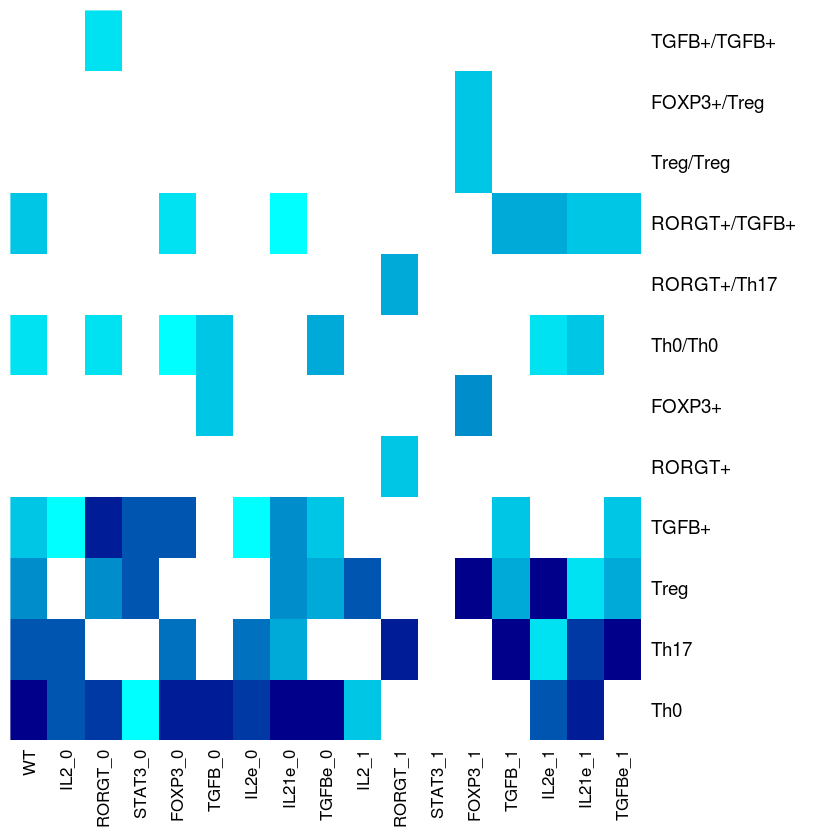

In [6]:
# Obtain mutants
mutants <- perturbNetworkFixedNodes(net)

# Label all mutants
labels <- lapply(rownames(mutants), function(states) {
    states <- as.numeric(unlist(strsplit(states, "/")))
    label <- lapply(states, function(s) {
        s <- int2binState(s, net$genes)
        l <- labelState(s, net$genes, labels.rules$labels, labels.rules$rules)
    })  
    label <- paste(label, collapse='/')
})
mutants$label <- as.character(labels)

#Group by label
mutants[is.na(mutants)] <- 0 # NAs to 0
mutants.by.label <- by(mutants[, 1:(length(mutants)-1)], mutants$label, colSums) #colSums by label
mutants.by.label <- t(sapply(mutants.by.label, function(label) label )) #simplify and transpose

#Order
colnames(mutants.by.label) <- lapply(colnames(mutants.by.label), function(s) {
    unlist(strsplit(s, split='.', fixed=TRUE))[1]
})
mutants.by.label <- mutants.by.label[ c(
    'Th0', 'Th17', 'Treg', 'TGFB+', 'RORGT+', 'FOXP3+',
    'Th0/Th0', 'RORGT+/Th17', 'RORGT+/TGFB+', 
    'Treg/Treg', 'FOXP3+/Treg', 'TGFB+/TGFB+'
) , ]

#Plot
mutants.by.label.matrix <- data.matrix(mutants.by.label) #convert to matrix
mutants.by.label.matrix[mutants.by.label.matrix==0] <- NA #replace 0s for NAs
colfunc <- colorRampPalette(c("cyan", "darkblue")) #nice color scale
mutants.heatmap <- heatmap(mutants.by.label.matrix,  # the heatmap
                            Rowv=NA, Colv=NA, 
                            col= colfunc(10),
                            #col=brewer.pal(3,"Blues"), 
                            scale="column", margins=c(5,10))

## Fixed environments

The state of a network usually depends in external factors -that can be modeled as inputs. Fixing the value of the functions can also be used to study the effect of the environment in the differentiation and robustness of different cell types. Most cell-types are higly dependent on the cytokines in the environment. This can be simulated by fixing the values of the inputs of the network according to the different environments\cite{Thieffry}. 

In [7]:
environments<- list(
    label=c('All', 'pro-Th0', 'pro-Th17', 'pro-iTreg'),
    nodes=list( c(NA),c('IL2e', 'IL21e', 'TGFBe'),c('IL2e', 'IL21e', 'TGFBe'),c('IL2e', 'IL21e', 'TGFBe')  ),
    values=list( c(NA), c(0, 0, 0), c(0, 1, 1), c(1, 0, 1) )     
)
environments

$label
[1] "All"       "pro-Th0"   "pro-Th17"  "pro-iTreg"

$nodes
$nodes[[1]]
[1] NA

$nodes[[2]]
[1] "IL2e"  "IL21e" "TGFBe"

$nodes[[3]]
[1] "IL2e"  "IL21e" "TGFBe"

$nodes[[4]]
[1] "IL2e"  "IL21e" "TGFBe"


$values
$values[[1]]
[1] NA

$values[[2]]
[1] 0 0 0

$values[[3]]
[1] 0 1 1

$values[[4]]
[1] 1 0 1

The __BoolNetPerturb__  function __perturbNetworkFixedNodes()__ can simulate multiple fixed genes if we pass them as a vector inside a list. For example:

### NOTE Why is it not plotting Th17!!!

,All,pro-Th0,pro-Th17,pro-iTreg
Th0,88,23,0,0
Th17,62,0,32,8
Treg,41,0,0,18
TGFB+,27,9,0,0
Th0/Th0,16,0,0,0
RORGT+/TGFB+,22,0,0,6


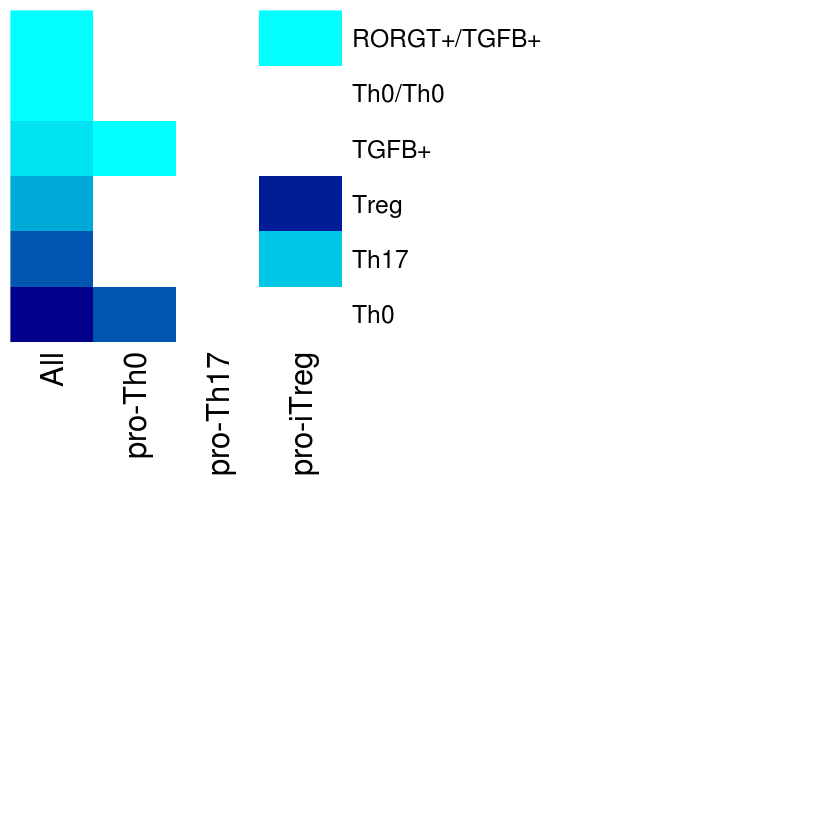

In [8]:
# Simulate environments
env.attr <- perturbNetworkFixedNodes(net, environments$nodes, environments$value, environments$label)
#env.attr

# label attractors
env.attr$label <- unlist(lapply(rownames(env.attr), function(states) {
    states <- as.numeric(unlist(strsplit(states, "/")))
    label <- lapply(states, function(s) {
        s <- int2binState(s, net$genes)
        l <- labelState(s, net$genes, labels.rules$labels, labels.rules$rules)
    })  
    label <- paste(label, collapse='/')
}))

# group by label
env.attr[is.na(env.attr)] <- 0 # NAs to 0
env.attr.by.label <- by(env.attr[, 1:(length(env.attr)-1)], env.attr$label, colSums) #colSums by label
env.attr.by.label <- t(sapply(env.attr.by.label, function(label) label )) #simplify and transpose
#env.attr.by.label

# rename and order
colnames(env.attr.by.label) <- lapply(colnames(env.attr.by.label), function(s) {
    unlist(strsplit(s, split='.', fixed=TRUE))[1]
})
env.attr.by.label <- env.attr.by.label[ c(
    'Th0', 'Th17', 'Treg', 'TGFB+', 'Th0/Th0', 'RORGT+/TGFB+') , ]
env.attr.by.label

# plot
env.attr.by.label.matrix <- data.matrix(env.attr.by.label) #convert to matrix
env.attr.by.label.matrix[env.attr.by.label.matrix==0] <- NA #replace 0s for NAs
colfunc <- colorRampPalette(c("cyan", "darkblue")) #nice color scale
env.attr.heatmap <- heatmap(env.attr.by.label.matrix,  # the heatmap
                            Rowv=NA, Colv=NA, 
                            col= colfunc(10),
                            scale="column", margins=c(25,25))

## Truth table

Trough evolution the regulatory interactions of an organism can change. This changes are not always loss-of-function mutations or over-expressions, they can also be smaller changes in the regulatory function. For example, the regulatory sequence of a gene can be altered, two independent regulators can become synergetic, or a positive interaction can become negative. However, this changes can also occur during the life of an organism: changes in the epigenetic marks, disordered domain proteins, and alternate spliccing can alter the regulatory functions\cite{Newman2014}. It is possible that there are mistakes in the construction of the network when the fine regulatory logic is uncertain. It is possible to simulate this mutants by altering the truth table of the function, partialy changing its regulatory logic. This partial changes in the functions have also been used to study the evolvability of biological systems, as the regulation of the gene expression can be mediated by changes in the promotors.

To do this we will use truth tables. Truth tables are a representation of Boolean functions. They have one column for each input variable, and one final column for all of the possible results of the logical operation that the table is meant to represent.

For example, the funtion:
> C = A and not B

Can be represented as:


| A | B | C |
|---|---|---|
| 0 | 0 | 0 |
| 0 | 1 | 0 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

We can perturb this table by changing one of the values of the truth table.

| A | B | C* |
|---|---|---|
| 0 | 0 | 0 |
| 0 | 1 | __1__ |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

This new table corresponds to the function:

> C = A xor B



We can simulate perturbations in the truth table using the __BoolNet__ function __perturbNetwork()__ and compare this results with the attractors of our WT network. Here we show the difference between the two sets of attractors. As __perturbNetwork()__ randomly changes a value of the table it is a good idea to repeat the experiment multiple times (see BoolNet package vignate for more information).

In [9]:
perturb.truth.table.differences <- function(net) {
    perturbed.net <- perturbNetwork(net, perturb="functions")
    pertubed.attr <- getAttractors(perturbed.net)
    pertubed.attr.df <- attractor2dataframe(pertubed.attr)
    #pertubed.attr.df
    setdiff(attr.df$involvedStates, pertubed.attr.df$involvedStates)
    }

replicate(10, perturb.truth.table.differences(net))

[[1]]
[1] "1"  "65"

[[2]]
[1] "16"      "144"     "178/181" "242/245"

[[3]]
[1] "57"  "121"

[[4]]
character(0)

[[5]]
[1] "96/101"

[[6]]
 [1] "0"      "1"      "4"      "16"     "33"     "36"     "57"     "68"    
 [9] "65"     "97"     "100"    "121"    "96/101"

[[7]]
[1] "57"  "121" "185" "249"

[[8]]
[1] "4"      "36"     "68"     "100"    "96/101"

[[9]]
[1] "0"   "1"   "4"   "16"  "68"  "65"  "144" "150" "214"

[[10]]
character(0)

# Updating perturbations
    
The effect of the order in which the functions are evaluated can also be studied. Studying the robustness of the updating schema is useful for predicting the effect of temporal differences and developmental noise in the dynamic regulation of different proteins.

An other possible perturbation of the dynamic is to alter the sucessor states. Boolean regulatory networks are deterministic, the state in this time step determines the state in the next time step. However, it is possible to alter the successor, changing the transition graph. This can alter -or not- the trajectory of the simulation and change the attractor. This is equivalent to developmental noise in the differentiation process of a cell.

## Synchronous vs asynchronous

In a discrete regulatory network the value of a node $n$ in $t+1$ is a function of the values of its regulators in the time $t. However, we can [update the value of the nodes in different ways](http://www.biorxiv.org/content/biorxiv/early/2014/10/19/010504.full.pdf). The two main schemas for updating are synchronous -where all functions are evaluated at the same time- or asynchronous -where each function is evaluated independently. 
If synchronous updates are used each state the transition space has only one successor. However, if asynchronous updates are used each state the transition space can have more than one successor. Complex attractors depend on the updating policy and are harder and more expensive to compute in the asynchronous case. 

Biologicaly speaking, synchronous updates supose that all the processes happen at exactly the same time, while asynchronous updates supose that the processes do not.  If a process is faster than an other, or if there is a lag in its regulation, it will affect the dynamic of the regulatory logic. While most biological regulatory functions are asynchronous, it is easier to study the synchronous schema. 

Lets compute the synchronous and asynchronous attractors and see the number of attractors each method found. 

In [10]:
attr.sync <- getAttractors(net)
attr.async <- getAttractors(net, type="asynchronous")
length(attr.sync$attractors)
length(attr.async$attractors)

[1] 22

[1] 9

The asynchronous method returns less attractors.  All the asynchronous attractors are also in the synchronous attractors, but the reverse is not true. In particular, most cycles tend to dissapear, as they are not robust to the update schema.
Synchronous updates are deterministic, this means each state has only one sucessor. However, in asynchoronous updates, states can have more than one sucessor, which makes it hard to determine the basin size. This can complicate the analysis of the system and add computational time. It is for this reason that synchronous updating is usually used.
Asynchronous updates usually result in less attractors, however, all the attractors present in the asynchronous update will be present in the synchronous. It is important to check the asynchronous attractors as complex attractors -specially cyclic attractors- are not robust to the update method and may not occur in biological systems, which tend to be asynchronous.

## Transition table
    

The trajectory of the regulatory network can be expressed as a transition table, where each state is followed by an other according with the differentiation functions. Perturbing the transitions between states can show the robustness to noise in the dynamic trajectory in the system.

We can do simulate this perturbations in the transitions using the __BoolNet__ function __perturbNetwork()__. As perturbNetwork() randomly changes the transition table it is a good idea to repeat the experiment multiple times.

In [11]:
perturb.transition.table.differences <- function(net) {
    perturbed.net <- perturbNetwork(net, perturb="transitions", numStates=10)
    pertubed.attr <- getAttractors(perturbed.net)
    pertubed.attr.df <- attractor2dataframe(pertubed.attr)
    #pertubed.attr.df
    setdiff(attr.df$involvedStates, pertubed.attr.df$involvedStates)
    }

replicate(10, perturb.transition.table.differences(net))

[[1]]
[1] "1"

[[2]]
[1] "33"

[[3]]
[1] "65"  "150"

[[4]]
[1] "178/181" "242/245"

[[5]]
[1] "36"

[[6]]
character(0)

[[7]]
[1] "4"

[[8]]
[1] "121"

[[9]]
[1] "242/245"

[[10]]
[1] "249"     "178/181"

# States-and-Trajectories

Until now we have discused perturbations that occur in the functions or the evaluation of the regulatory network. However, once the attractors have been reached, they are subjected to other perturbations in the state of the system. This perturbations do not alter the wiring and updating of the network, but its state. This perturbations are transient, as the functions remain the same, it is only the state that is perturbed for a certain time, affecting its trajectory.

Biologicaly, this is equivalent to signals of the environment or intrinsic process of the cell that change the expression of an element for a certain time. For example, most drugs change the micro-environment of the organism while they are ingested, but once the treatment ends the perturbation ends. An other example of transient perturbations in biological systems is stochastic noise.

Lets take Th0 attractor 0 and expose it to a Th17 environment for one time step to see the trajectory this perturbation followed.

In [12]:
state <- 0
new.traj <- perturbPathToAttractor(int2binState(state, net$genes), net, 
                c('IL2e', 'IL21e', 'TGFBe'), c(0,1,1),
                time=1, returnTrajectory = TRUE)
new.traj

,IL2,RORGT,STAT3,FOXP3,TGFB,IL2e,IL21e,TGFBe
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,1
3,0,0,1,0,1,0,0,0
4,0,1,1,0,0,0,0,0
5,0,0,1,0,0,0,0,0


As we can see, the resulting attractor is different, but the resulting label is the same (Th0).

A question we can ask ourselves is if an attractor is more sensible to perturbations in a particular node, and what transitions do this perturbations cause.
Lets take the Th0 0 attractor again and perturb one by one all its nodes for one time step.

In [17]:
state.int <- 0
label <- "Th0"
state <- int2binState(state.int, net$genes)

# perturb all nodes for time = 1
perturbations <- sapply(names(state), function(node) {
    new.value <- as.integer(!state[[node]])
    new.state <- perturbPathToAttractor(state, net, 
                node, new.value, time=1)
    new.state <- new.state$attractors[[1]]$involvedStates
    new.label <- labelState(int2binState(new.state, net$genes), 
                        net$genes, labels.rules$labels, labels.rules$rules )
    c(state.int, label, node, new.value, new.state, new.label)
})
# clean data and rename columns
perturbations <- t(perturbations)
colnames(perturbations) <- c("ini.state", "ini.attr", "pert.node", "pert.value", "mod.state", "mod.attr")
perturbations

,ini.state,ini.attr,pert.node,pert.value,mod.state,mod.attr
IL2,0,Th0,IL2,1,1,Th0
RORGT,0,Th0,RORGT,1,4,Th0
STAT3,0,Th0,STAT3,1,4,Th0
FOXP3,0,Th0,FOXP3,1,16,TGFB+
TGFB,0,Th0,TGFB,1,16,TGFB+
IL2e,0,Th0,IL2e,1,1,Th0
IL21e,0,Th0,IL21e,1,4,Th0
TGFBe,0,Th0,TGFBe,1,16,TGFB+


This table shows us all the possible one node perturbations for a state and their resulting attractors and labels. As we can see the Th0 attractor is very sensible to perturbations. However, most of the perturbations end in Th0 attractors, only a few end in TGFB+ attractors.
Using this method we can determine which cell types are more robust to perturbations and which are more plastic to perturbations.
It is also possible to study wether the length of the perturbations affects the transitions of the system.

# Conclusions

It is possible to perturb the functions, the dynamics or the states ofthe RN. Each type of perturbation can be used to study different biological phenomena.

Depending on the question that needs to be adress is the methodology you use.



Target		|	Perturbation		|	Biological equivalent
------------|-----------------------|---------------------------
Function	|	Fixed functions		|	Knock-out and over expressions, permanent changes in environment
			|	Transition table	|	Misconstruction of the network, small changes in regulation, evolvability
Dynamic		|	Updating			|	Time and hierarchy of biological processes.
			|	State transitions	|	Transient biological behaivor.
Attractor	|	State of nodes		|	Temporal changes in expression, transient environmental signals.
			|	Stochastic			|	Biological stochastic processes.


This analysis let us verify this model.  To verify the model it is important to:
* Compare with biological data
* Avoid overfitting, make sure that small mistakes wont affect the model to much
* Consider the limitations of the modeling tool and why this limitations create artifacts.


Robustness analysis let us understand the whole system and its dynamical properties. This way, it is possible to realize global studies that show the roles of specific nodes in the dynamic behaivor of the whole system.

Important to define the properties that are measured and the level at which they are measured (stability, plasticity and robustness). 
We need to create quatitative measures for plasticity. Boolean networks might be useful, as they integrate levels to create a system approach, and it is possible to do some seripus sampling. However, before we can do thise still requiere more work to understand the general properties that we can expect from random and biological networks. 

We hope this software is useful to understand robustness.
